## This is to experiement with the dependencies among crewAI agents

In [ ]:
!pip install crewai==0.28.8 crewai_tools==0.1.6 langchain_community==0.0.29 networkx==2.8.8

In [ ]:
import os
# from utils import get_openai_api_key
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["OPENAI_MODEL_NAME"] = 'gpt-4o-mini'

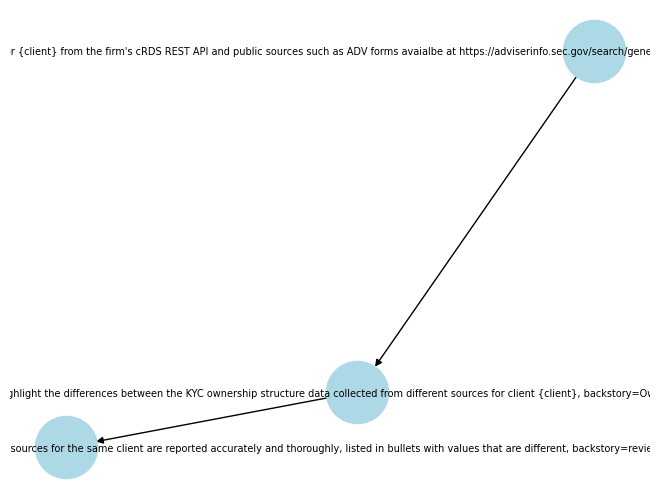

 [DEBUG]: == Working Agent: KYC Researcher
 [INFO]: == Starting Task: Gather ownership data from various data sources for Deutsche Bank AG
 

After comparing the ownership data for Deutsche Bank AG from cRDS with the data from the public source ADV, I have identified several material differences. 

1. The percentage of ownership by institutional investors varies between the two sources. cRDS lists a higher percentage of institutional ownership compared to the data from ADV.

2. The specific institutional investors holding significant stakes in Deutsche Bank AG also differ between the two sources. Some institutions are listed in cRDS but not in ADV, and vice versa.

3. The breakdown of ownership by geographical region shows discrepancies, with cRDS indicating higher ownership from European investors while ADV shows a more diversified global ownership structure.

4. There are inconsistencies in the reporting of ownership stakes held by insiders and major shareholders. The data from cRDS 

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from crewai import Task, Agent, Crew


# Define agents
researcher = Agent(
    role="KYC Researcher",
    goal="Gather the KYC ownership structure data for {client} from the firm's cRDS"
    " REST API and public sources such as ADV forms avaialbe at https://adviserinfo.sec.gov/search/genericsearch/firmgrid",
    backstory="You are a KYC researcher supporting the onboarding process for client - {client} at a major European bank."
    " Your responsibilities are to collect the most up-to-date information about the client, {client}, from internal and external data sources to be analyzed by our KYC analyst on the case.",
    )
analyst = Agent(
    role="KYC Analyst",
    goal="Highlight the differences between the KYC ownership structure data collected from different sources for client {client}",
    backstory="Ownership structure data in cRDS could be out-of-sync with the data from public source such as ADV. It's critical for the analyst the list all the material differences acurately and completely",)
reviewer = Agent(
    role="KYC Reviewer",
    goal="To ensure that differences in ownership structure data from various sources for the same client are reported accurately and thoroughly, listed in bullets with values that are different",
    backstory="reviewer's job is to ensure the quality of the report by analyst, making sure they are accurate, complete and easily to read.")

# Define tasks
research_task = Task(description="Gather ownership data from various data sources for {client}", agent=researcher, expected_output="Ownership data from cRDS and ADV forms in their own json strings")
analyze_task = Task(description="Report delta in ownership data for {client} gathered by researcher", agent=analyst, expected_output="A report highlighting the differences in ownership data in bullet points")
review_task = Task(description="Review delta report by analyst. if unsatisfied,  ask analyst to improve with detailed feedback. ", agent=reviewer, expected_output="feedback on the delta report")

# Create a task graph
task_graph = nx.DiGraph()
task_graph.add_edge(research_task, analyze_task)
task_graph.add_edge(analyze_task, review_task)

# Visualize the task graph
nx.draw(task_graph, with_labels=True, node_size=2000, node_color="lightblue", font_size=7)
plt.show()

# Create crew
crew = Crew(
    agents=[researcher, analyst, reviewer],
    tasks=[research_task, analyze_task, review_task],
    verbose=2
)

# Execute crew
inputs = {
    "client": "Deutsche Bank AG",
    "inquiry": "Please help verify the ownership structure data for the client as part of the KYC onboarding process."
}
result = crew.kickoff(inputs)
print(result)